## Exercises classifiers and evaluation

These exercises follow the general setup of [this tutorial in the R language](https://compgenomr.github.io/book/model-tuning-and-avoiding-overfitting.html).

In this exercise session you will go through some concepts related to classifiers and evaluation in Python. Parts of the code are already implemented, you need to fill in the remaining parts.

Your code should produce figures similar to the ones in the tutorial, but because the data you use is different, you will not get the same values.

If you want to see whether you get the same plots for the tutorial's data, check earlier chapters of the tutorial.

## Load all the things

In [1]:
# Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Clone repository with example images
!rm -rf fyp2022-imaging
!git clone https://github.com/vcheplygina/fyp2022-imaging.git


# Load features and labels
file_data = 'fyp2022-imaging/data/example_ground_truth.csv'
file_features = 'fyp2022-imaging/features/features.csv'

df = pd.read_csv(file_data)
features = pd.read_csv(file_features)


# Combine variables we want in one place
df = df.drop(['image_id','seborrheic_keratosis'],axis=1)
df['area'] = features['area']
df['perimeter'] = features['perimeter']

# Please remember that area and perimeter alone are often not sufficient for classification.
# When doing your project, you could also try the other features here.

print(df.head())

c:\Users\andre\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
'rm' is not recognized as an internal or external command,
operable program or batch file.
fatal: destination path 'fyp2022-imaging' already exists and is not an empty directory.

   melanoma      area  perimeter
0       0.0  216160.0     2013.0
1       0.0  130493.0     1372.0
2       0.0  205116.0     1720.0
3       0.0  161705.0     1344.0
4       0.0  317040.0     2063.0


In [75]:
# Prepare development (train and validation) and test splits
from sklearn.model_selection import train_test_split

x = df[['area','perimeter']]
y = df[['melanoma']]

dev_x, test_x, dev_y, test_y = train_test_split(
        x, y, stratify=y, random_state=0)

train_x, val_x, train_y, val_y = train_test_split(
        dev_x, dev_y, stratify=dev_y)


## TODOs for students

# For reducing computation, you may want to reduce the size of the selected data using train_size and test_size parameters.
# However, reducing the size of the dataset will lead to more variability of your results

# Think about exercises from last lecture, do we still want to do anything with the data? Do it here

# ANSWER: Using StandardScaler, fit only on train

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform train_x
train_x = scaler.fit_transform(train_x)

# Transform val_x and test_x using the same scaler (do not fit again to avoid data leakage)
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)


0.7045454545454545


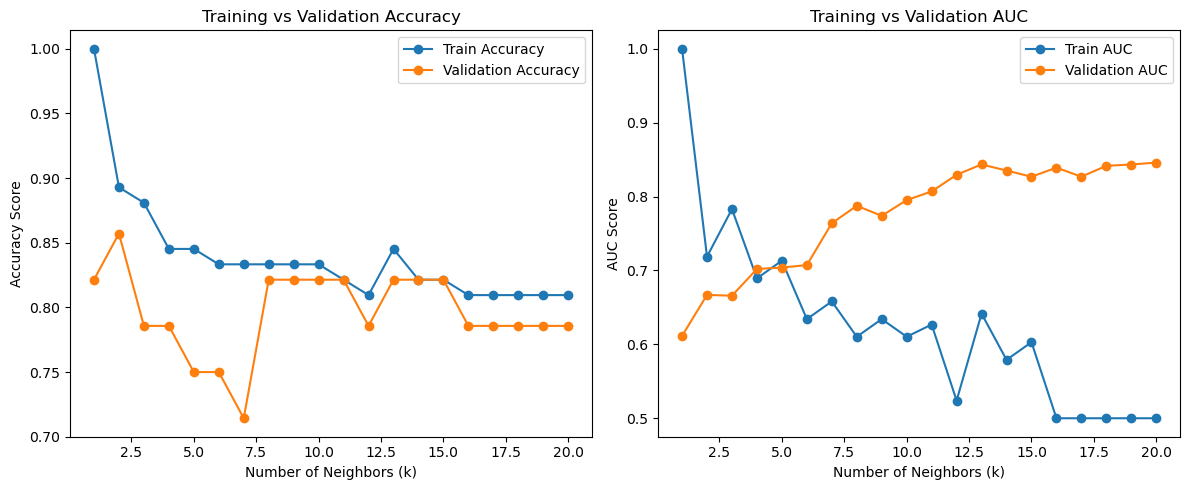

In [63]:
#Import classifier and metric
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score


# Example of training a classifier
knn1 = KNeighborsClassifier(n_neighbors=1) # other hyperparameters possible
knn1_trained = knn1.fit(train_x, np.ravel(train_y))

# Example of prediction
val_pred_knn1 = knn1_trained.predict(val_x)
val_auc_knn1 = roc_auc_score(val_y, val_pred_knn1)

print(val_auc_knn1)


# TODOs for students:

# 1) Try out different parameters of K using a for loop
from sklearn.metrics import roc_auc_score, accuracy_score

# Define the parameter grid for k
possible_params = {'n_neighbors': range(1, 21)}  # Try k values from 1 to 20

# Create a KNN classifier
knn = KNeighborsClassifier()

# Extract results from GridSearchCV
k_values = possible_params['n_neighbors']
mean_test_scores = results['mean_test_score']  # Mean validation AUC for each k

# Initialize lists to store training and validation scores
train_auc_scores = []
train_accuracy_scores = []
val_accuracy_scores = []

# Loop through each k value to compute training and validation scores
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x, np.ravel(train_y))
    
    # Predict on training and validation data
    train_pred = knn.predict(train_x)
    val_pred = knn.predict(val_x)
    
    # Compute training AUC and accuracy
    train_auc = roc_auc_score(train_y, train_pred)
    train_accuracy = accuracy_score(train_y, train_pred)
    
    # Compute validation accuracy
    val_accuracy = accuracy_score(val_y, val_pred)
    
    # Store scores
    train_auc_scores.append(train_auc)
    train_accuracy_scores.append(train_accuracy)
    val_accuracy_scores.append(val_accuracy)


# 2) Make a plot of the training vs validation AUC in the same plot.
# You can also plot the accuracy metric in a different plot.
# Remember to add proper axes labels and legend to the plots (Fig 5.5 in tutorial)
plt.figure(figsize=(12, 5))

# Plot AUC scores
plt.subplot(1, 2, 2)
plt.plot(k_values, train_auc_scores, label='Train AUC', marker='o')
plt.plot(k_values, mean_test_scores, label='Validation AUC', marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AUC Score')
plt.title('Training vs Validation AUC')
plt.legend()

# Plot accuracy scores
plt.subplot(1, 2, 1)
plt.plot(k_values, train_accuracy_scores, label='Train Accuracy', marker='o')
plt.plot(k_values, val_accuracy_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Q: Do you see the values you would expect?
# Answer: The plot should show that as k increases, the training AUC and accuracy may decrease, 
# while the validation AUC and accuracy may initially improve and then stabilize or 
# decrease. This is because a smaller k may overfit the training data, 
# while a larger k may generalize better but lose some predictive power.


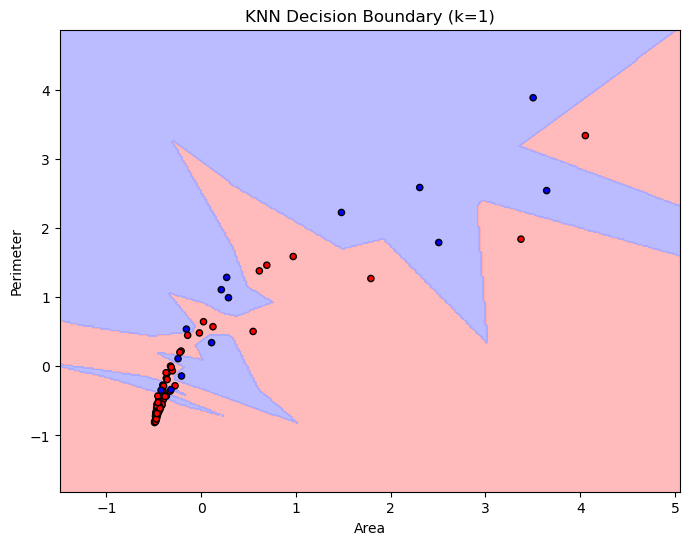

In [ ]:
# Visualize the decision boundary

# TODO for students:

chosen_k = 1

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Function to plot decision boundary
def plot_decision_boundary(X, y, model, title):
    # Create a mesh grid of points
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the class for each point in the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(8, 6))
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])  # Light colors for the regions
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])  # Bold colors for the points
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('Area')
    plt.ylabel('Perimeter')
    plt.show()

# Use chosen knn
chosen_knn = KNeighborsClassifier(n_neighbors=chosen_k)
chosen_knn.fit(train_x, np.ravel(train_y))

# Plot decision boundary for the best k
plot_decision_boundary(train_x, np.ravel(train_y), chosen_knn, f'KNN Decision Boundary (k={chosen_k})')

max_depth = 1:
  Train AUC: 0.8284, Validation AUC: 0.5611
  Train Accuracy: 0.8315, Validation Accuracy: 0.6522

max_depth = 3:
  Train AUC: 0.9150, Validation AUC: 0.4889
  Train Accuracy: 0.8989, Validation Accuracy: 0.6522

max_depth = 5:
  Train AUC: 0.9861, Validation AUC: 0.4611
  Train Accuracy: 0.9775, Validation Accuracy: 0.6087

max_depth = 7:
  Train AUC: 1.0000, Validation AUC: 0.4611
  Train Accuracy: 1.0000, Validation Accuracy: 0.6087

max_depth = 10:
  Train AUC: 1.0000, Validation AUC: 0.4611
  Train Accuracy: 1.0000, Validation Accuracy: 0.6087

max_depth = 100:
  Train AUC: 1.0000, Validation AUC: 0.4611
  Train Accuracy: 1.0000, Validation Accuracy: 0.6087



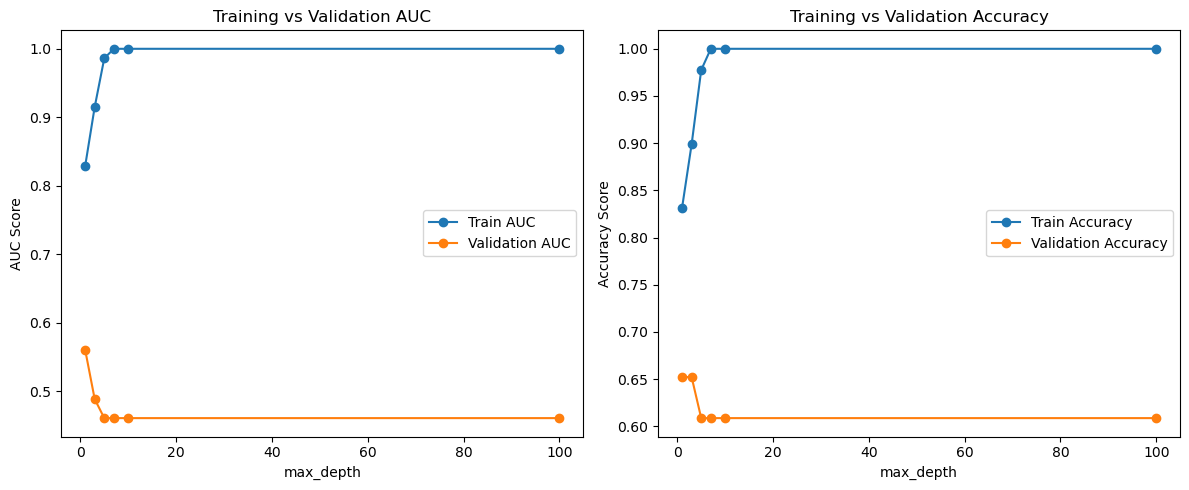

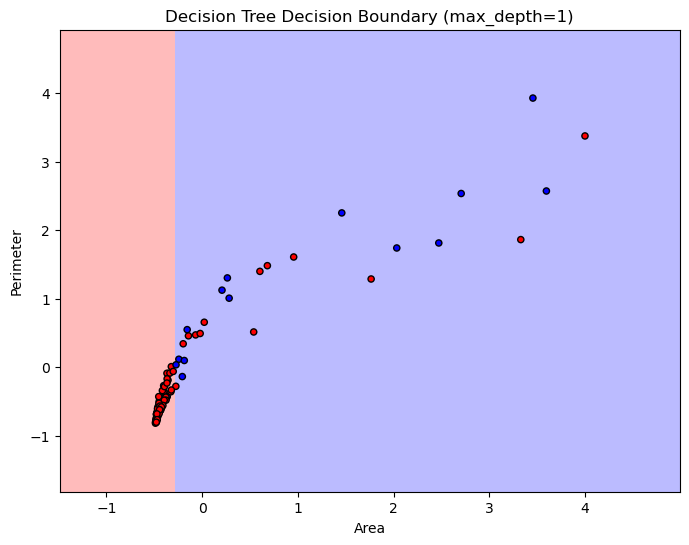

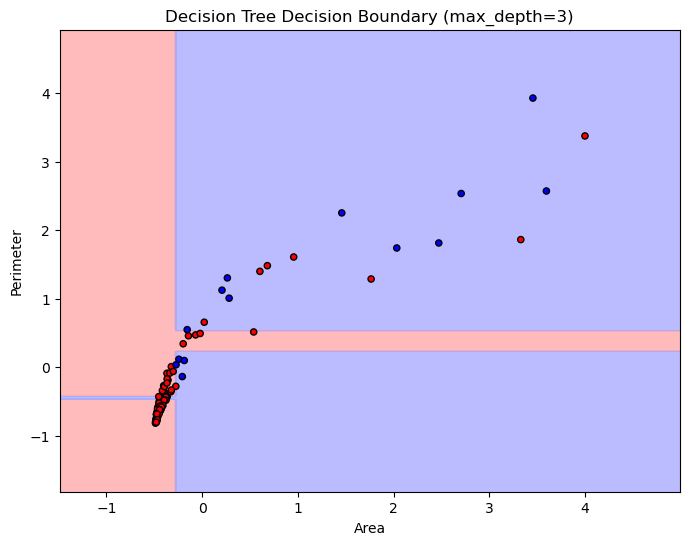

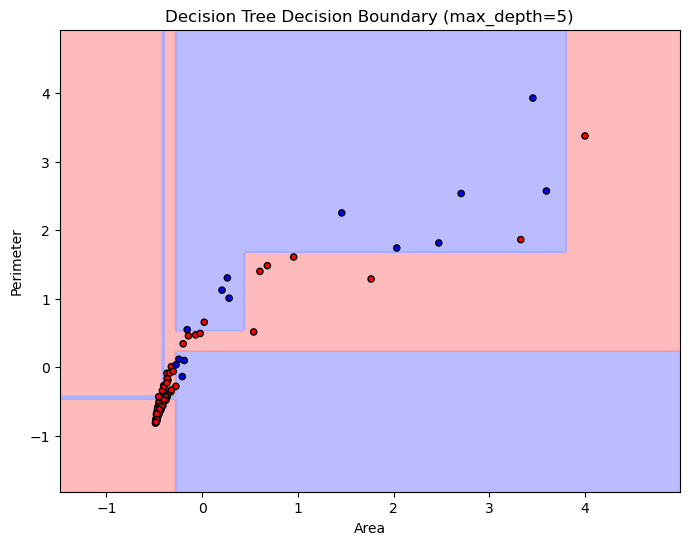

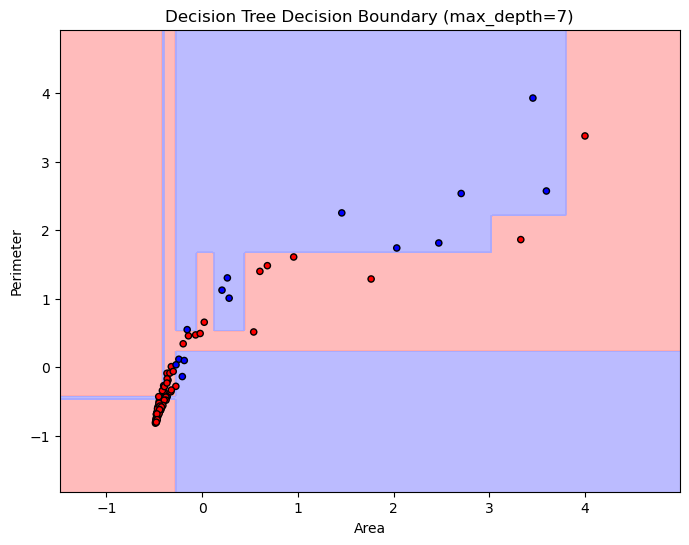

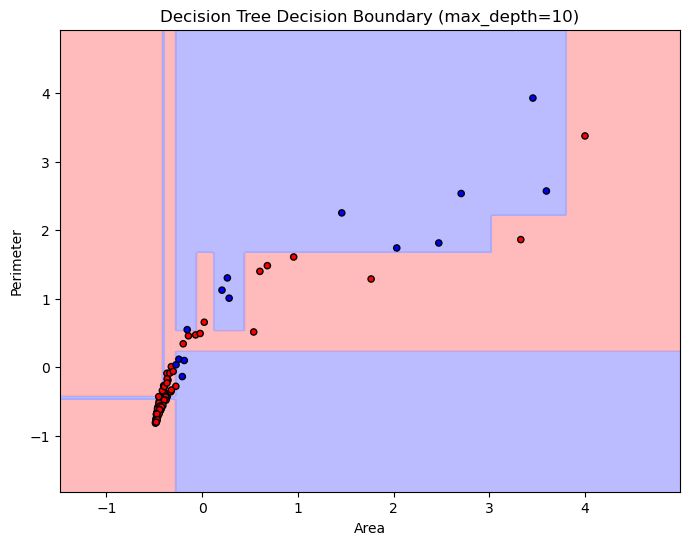

In [ ]:
# Now let's try with a different classifier
from sklearn.tree import DecisionTreeClassifier

# TODOs for students:

# 1) Investigate the max_depth parameter of the classifier, and repeat the procedure above

# 2) Optionally, look at some other parameters of the classifier.

from sklearn.metrics import roc_auc_score, accuracy_score

# List of max_depth values to try
max_depth_values = [1, 3, 5, 7, 10, 100]  # Probably fully pure by 10 or 100, so likely no difference in trees

# Initialize lists to store training and validation scores
train_auc_scores = []
val_auc_scores = []
train_accuracy_scores = []
val_accuracy_scores = []

# Loop through each max_depth value
for depth in max_depth_values:
    # Create and train the Decision Tree classifier
    dt = DecisionTreeClassifier(max_depth=depth, random_state=0)
    dt.fit(train_x, np.ravel(train_y))
    
    # Predict on training and validation data
    train_pred = dt.predict(train_x)
    val_pred = dt.predict(val_x)
    
    # Compute training and validation AUC
    train_auc = roc_auc_score(train_y, train_pred)
    val_auc = roc_auc_score(val_y, val_pred)
    
    # Compute training and validation accuracy
    train_accuracy = accuracy_score(train_y, train_pred)
    val_accuracy = accuracy_score(val_y, val_pred)
    
    # Store scores
    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)
    train_accuracy_scores.append(train_accuracy)
    val_accuracy_scores.append(val_accuracy)

    # Print results for this depth
    print(f"max_depth = {depth}:")
    print(f"  Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")
    print(f"  Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print()

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot AUC scores
plt.subplot(1, 2, 1)
plt.plot(max_depth_values, train_auc_scores, label='Train AUC', marker='o')
plt.plot(max_depth_values, val_auc_scores, label='Validation AUC', marker='o')
plt.xlabel('max_depth')
plt.ylabel('AUC Score')
plt.title('Training vs Validation AUC')
plt.legend()

# Plot accuracy scores
plt.subplot(1, 2, 2)
plt.plot(max_depth_values, train_accuracy_scores, label='Train Accuracy', marker='o')
plt.plot(max_depth_values, val_accuracy_scores, label='Validation Accuracy', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy Score')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize decision boundaries for selected max_depth values
selected_depths = [1, 3, 5, 7, 10]  # Example depths to visualize

for depth in selected_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=0)
    dt.fit(train_x, np.ravel(train_y))
    plot_decision_boundary(train_x, np.ravel(train_y), dt, f'Decision Tree Decision Boundary (max_depth={depth})')

max_depth = 5, min_samples_split = 2, min_samples_leaf = 1, criterion = gini
  Train AUC: 0.7353, Validation AUC: 0.5783
  Train Accuracy: 0.8929, Validation Accuracy: 0.8214



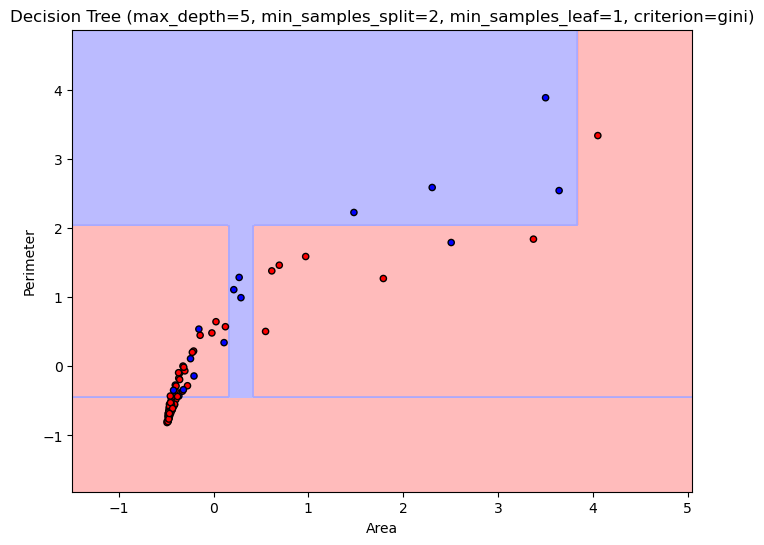

In [90]:
max_depth = 5  # Set a single max_depth value like above

# Experiment with other parameters
min_samples_split = 2  # Minimum number of samples required to split a node
min_samples_leaf = 1   # Minimum number of samples required to be at a leaf node
criterion = 'gini'     # Splitting criterion: 'gini' or 'entropy'

# Create and train the Decision Tree classifier
dt = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    criterion=criterion,
    random_state=0
)
dt.fit(train_x, np.ravel(train_y))

# Predict on training and validation data
train_pred = dt.predict(train_x)
val_pred = dt.predict(val_x)

# Compute training and validation AUC
train_auc = roc_auc_score(train_y, train_pred)
val_auc = roc_auc_score(val_y, val_pred)

# Compute training and validation accuracy
train_accuracy = accuracy_score(train_y, train_pred)
val_accuracy = accuracy_score(val_y, val_pred)

# Print results
print(f"max_depth = {max_depth}, min_samples_split = {min_samples_split}, min_samples_leaf = {min_samples_leaf}, criterion = {criterion}")
print(f"  Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")
print(f"  Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print()

# Visualize the decision boundary
plot_decision_boundary(train_x, np.ravel(train_y), dt, f'Decision Tree (max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, criterion={criterion})')

In [80]:
print(train_x.shape)

(84, 2)


## Variance of performance depending on the split

Notice the random state parameter of the classifiers. Why do we need this?

You can try different choices for this parameter and investigate the effect on the results

In [32]:
# TODO for students:

# Choose one of the experiments above, and create the performance vs parameter plot, for two different seeds




1) What kind of strategies could you use to obtain more reliable performances?

ANSWER: More data, and/or use multiple splits and average


2) What does this tell you about the random_state, how is it different from for example a tunable k parameter?

ANSWER: Do not tune the random state

## Cross-validation

In this part we will use cross-validation on the development set to find good k / max_depth parameters

In [87]:
from sklearn.model_selection import KFold

# Create the folds
kfold = KFold(n_splits=5, random_state=None, shuffle=False)
kfold.get_n_splits(dev_x, dev_y)

# Check the contents of the folds
for i, (train_index, dev_index) in enumerate(kfold.split(dev_x)):

    print(f"Fold {i}:")

    print(f"  Train: index={train_index}")

    print(f"  Test:  index={dev_index}")

# TODO for students:

# Investigate other parameters of the KFold


Fold 0:
  Train: index=[ 23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
  Test:  index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Fold 1:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
  Test:  index=[23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
Fold 2:
  Train: index=[  0   1   2   3   4   5   6   7   

## Other types of KFold

In many medical imaging applications instead of KFold we need to use GroupKFold or other options in the model_selection library.

**Question:**  

Why might we need to use GroupKFold? Does it apply to this example data you are using? And does it apply to the PAD-UFES data? Which variable creates the groups?



## Effect of noisy features

Uninformative/noisy features will affect the generalization ability of your classifiers.

In this part we add uninformative (not correlated to class label) features and test (some) classifiers

In [34]:
# Generate some noisy features
n_noisy_features = 20
noise = np.random.RandomState(42).uniform(0, 0.1, size=(df.shape[0], n_noisy_features))

# Add the noisy data to the informative features
x_noisy = np.hstack((df[['area', 'perimeter']], noise))


# TODO for students
# Investigate the behavior of classifiers with regards to overfitting

## Combining everything and final evaluation

The examples above give you an idea of how you can investigate the quality of different classifiers and parameters. To keep track of the results (on the development set) of the options you try, you might want to make a "result dataset" where you track all the classifier versions and the corresponding results. MLFlow also allows doing this, but we do not cover it in the course (but perhaps the TAs can show you)

Then once you have evaluated all the options, you can select some of the better ones, retrain them, now you can use the entire development set for retraining.

Your choice of these options needs to be reproducible in your project, i.e., you should not try out some classifiers/parameters and then completely remove them from your project.

You can evaluate the re-trained classifiers on the so far held-out test set. Your performances (how good each classifier was) might not reflect your results on the validation set.

You are NOT allowed to edit the classifiers after this point


In [35]:
# TODO for students

# Keep track of different classifiers/parameters with an array

# Select some better ones (e.g. top 3)

# Re-train

# Evaluate on held-out set

In [36]:
# After this point you are not allowed to adjust the classifier, otherwise you are overfitting!